In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from ripple_heterogeneity.utils import compress_repeated_epochs
import glob
import os
import pickle

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## make psth on ripple for ca1, pfc, and mec

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

all_sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
sessions = pd.DataFrame()
sessions["basepath"] = all_sessions.basepath.unique()
sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


In [ ]:
# psth_df = pd.DataFrame()
# cell_metrics = pd.DataFrame()
# for basepath in sessions.basepath:

#     st, cell_metric = loading.load_spikes(basepath)
#     ripples = loading.load_ripples_events(basepath)
#     replays_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

#     psth = functions.compute_psth(
#         st.data, replays_epochs.starts, bin_width=0.01, n_bins=100
#     )
#     psth_df = pd.concat([psth_df, psth], axis=1, ignore_index=True)
#     cell_metrics = pd.concat([cell_metrics, cell_metric], axis=0, ignore_index=True)

In [18]:
def get_region_psth(
    basepath,
    putativeCellType="Pyr",
    target_regions=["CA1", "PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],
):

    st, cell_metric = loading.load_spikes(
        basepath, brainRegion=target_regions, putativeCellType=putativeCellType
    )
    ripples = loading.load_ripples_events(basepath)
    replays_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    psth = functions.compute_psth(
        st.data, replays_epochs.starts, bin_width=0.01, n_bins=100
    )
    results = {"psth": psth, "cell_metric": cell_metric}
    return results

def load_results(save_path):
    sessions = glob.glob(os.path.join(save_path, "*.pkl"))
    psth_df = pd.DataFrame()
    cell_metrics = pd.DataFrame()
    for session in sessions:
        with open(session, "rb") as f:
            results = pickle.load(f)

        if results is None:
            continue

        if results["cell_metric"].shape[0] == 0:
            continue
        
        if results["cell_metric"].shape[0] != results["psth"].shape[1]:
            print("psth and cell_metric have different shapes")
            print(session)
        psth_df = pd.concat([psth_df, results["psth"]], axis=1, ignore_index=True)
        cell_metrics = pd.concat([cell_metrics, results["cell_metric"]], axis=0, ignore_index=True)
    return psth_df, cell_metrics

save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1"
)

batch_analysis.run(
    sessions,
    save_path,
    get_region_psth,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
psth_df, cell_metrics = load_results(save_path)

100%|██████████| 110/110 [00:00<00:00, 336.34it/s]


psth and cell_metric have different shapes
Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec013.944_958.pkl
psth and cell_metric have different shapes
Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec013.976_985.pkl
psth and cell_metric have different shapes
Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec016.1002_1023.pkl
psth and cell_metric have different shapes
Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec016.1025_1048.pkl
psth and cell_metric have different shapes
Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec016.694_711.pkl
psth and cell_metric have different shapes
Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec016.791_810.pkl
psth and cell_metric have different shapes
Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec016.813_831.pkl


In [23]:
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\region_psth_v1\Z__Data_Kenji_ec013.944_958.pkl"

with open(session, "rb") as f:
    results = pickle.load(f)

results["psth"]
results["cell_metric"]

,UID,ab_ratio,acg_asymptote,acg_c,acg_d,acg_fit_rsquare,acg_h,acg_refrac,acg_tau_burst,acg_tau_decay,...,troughtoPeakDerivative,bad_unit,tags_Bad,basename,basepath,sex,species,strain,geneticLine,cellCount


## add deep sup

In [8]:
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)


In [12]:
cell_metrics.brainRegion.unique()

array(['CA1', 'MEC', 'CA1sr', 'CA1sp', 'CA1so', 'PFC', 'EC3', 'EC5',
       'EC4', 'EC2', 'EC1', 'CA1slm'], dtype=object)

In [10]:
psth_df

,0,1,2,3,4,5,6,7,8,9,...,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996
-0.50,0.598802,0.119760,2.235529,0.658683,1.237525,0.778443,0.678643,1.237525,0.598802,0.698603,...,1.500134,0.616126,0.803643,0.562550,1.044736,1.982320,0.964372,0.241093,0.508974,0.482186
-0.49,0.479042,0.219561,2.674651,0.958084,0.798403,1.037924,0.558882,0.978044,0.558882,0.798403,...,1.232253,0.884008,1.178677,0.294669,1.178677,1.821591,0.857219,0.375033,0.535762,0.375033
-0.48,0.638723,0.139721,2.994012,0.978044,0.898204,0.638723,0.518962,0.998004,0.578842,0.938124,...,1.366193,0.401822,1.607286,0.535762,0.776855,2.169837,1.071524,0.375033,0.401822,0.348245
-0.47,0.998004,0.219561,2.534930,1.037924,1.097804,0.858283,0.638723,1.057884,0.578842,0.838323,...,1.634074,0.589338,1.526922,0.321457,0.830431,2.464506,0.616126,0.348245,0.455398,0.401822
-0.46,0.858283,0.179641,2.734531,0.778443,0.838323,0.658683,0.598802,1.177645,0.499002,0.738523,...,1.982320,0.562550,1.044736,0.508974,0.589338,2.276989,0.696491,0.294669,0.348245,0.375033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.46,0.798403,0.159681,2.654691,0.758483,0.798403,0.718563,0.778443,1.337325,0.758483,0.878244,...,1.366193,1.044736,1.312617,0.214305,1.044736,2.357353,0.723279,0.348245,0.401822,0.401822
0.47,0.738523,0.159681,2.475050,0.998004,1.037924,0.878244,0.598802,0.978044,0.698603,0.758483,...,1.339405,0.803643,1.312617,0.508974,1.017948,2.384141,0.723279,0.348245,0.267881,0.669703
0.48,0.738523,0.119760,2.295409,0.738523,0.578842,0.578842,0.479042,0.978044,0.499002,0.898204,...,1.125100,0.723279,1.580498,0.562550,0.803643,1.928744,0.857219,0.375033,0.294669,0.508974
0.49,0.998004,0.139721,2.814371,1.277445,0.758483,0.558882,0.618762,1.037924,0.678643,0.758483,...,1.178677,0.776855,1.607286,0.482186,0.535762,2.009108,0.937584,0.294669,0.589338,0.508974


In [9]:
def plot_psth_mean(psth_df,cell_metrics, region_idx, label):


    psth = psth_df.values[:,cell_metrics.brainRegion.str.contains(region_idx).values]

    psth_z = stats.zscore(psth, axis=0)
    plt.plot(psth_df.index, np.nanmean(psth_z, axis=1), label=label)
    plt.fill_between(
        psth_df.index,
        np.nanmean(psth_z, axis=1) - np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        np.nanmean(psth_z, axis=1) + np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        alpha=0.5,
    )
    plt.axvline(x=0, color="k", linestyle="--")
    plt.legend()

plot_psth_mean(psth_df,cell_metrics, "EC1|EC2|EC3|EC4|EC5|MEC", "mec")
plot_psth_mean(psth_df,cell_metrics, "CA1", "CA1")
plot_psth_mean(psth_df,cell_metrics, "PFC", "PFC")

# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").values].mean(axis=1),label="mec")
# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("CA1").values].mean(axis=1),label='ca1')
# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("PFC").values].mean(axis=1),label='pfc')
# plt.axvline(x=0, color="k", linestyle="--")
plt.legend()
plt.show()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 4997 but corresponding boolean dimension is 4990

In [138]:
from scipy.ndimage import gaussian_filter1d

def plot_psth_matrix(psth_df, cell_metrics, region_idx, label=None, ax=None, vmax=3, vmin=-3):

    psth = psth_df.values[:, cell_metrics.brainRegion.str.contains(region_idx).values]

    psth_smooth = gaussian_filter1d(psth, np.round(.020 / np.diff(psth_df.index)[0]),axis=0)

    # sort_idx = np.argsort(np.argmax(psth, axis=0))

    

    # max_mean_ratio = (psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1),:].max(axis=0) / psth_smooth.mean(axis=0))
    max_mean_ratio = (psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1),:].max(axis=0) / psth_smooth[(psth_df.index < -0.10),:].mean(axis=0))

    sort_idx = np.argsort(max_mean_ratio)

    if ax is None:
        plt.figure()
    ax = plt.gca()
    # sns.heatmap(
    #     stats.zscore(psth, axis=0)[:,sort_idx].T,
    #     ax=ax,
    #     cmap="bwr",
    #     vmax=3,
    #     vmin=-3,
    #     xticklabels=False,
    # )
    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr"
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm

# plot_psth_matrix(psth_df, cell_metrics, "CA1", "CA1")
# plot_psth_matrix(psth_df, cell_metrics, "EC1|EC2|EC3|EC4|EC5|MEC", "mec")
# plot_psth_matrix(psth_df, cell_metrics, "PFC", "PFC")



In [137]:
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

In [86]:
from scipy.ndimage import gaussian_filter1d
psth = psth_df.values[:, cell_metrics.brainRegion.str.contains("CA1").values]
psth = stats.zscore(psth, axis=0)
psth_smooth = gaussian_filter1d(psth, np.round(.020 / np.diff(psth_df.index)[0]),axis=0)


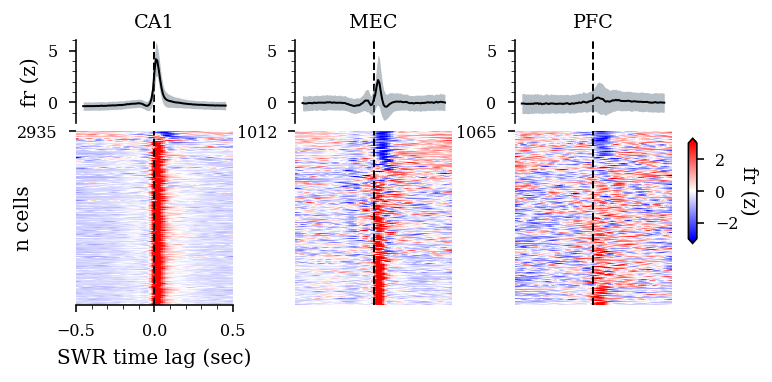

In [111]:
fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2,3)),constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.4)

y_min = -2
y_max = 6
heatmap_factor = 2

# # mean CI plots
ax0 = fig.add_subplot(gs[0, 0])
psth = psth_df.values[:, cell_metrics.brainRegion.str.contains("CA1").values]
psth = stats.zscore(psth, axis=0)
lower,upper= std_upper_lower(psth)
ax0.plot(psth_df.index,np.nanmean(psth,axis=1),'k',linewidth=1)
ax0.fill_between(psth_df.index, lower, upper, color="slategrey", alpha = .5, linewidth = 0)

ax1 = fig.add_subplot(gs[0, 1])
psth = psth_df.values[:, cell_metrics.brainRegion.str.contains("MEC").values]
psth = stats.zscore(psth, axis=0)

lower,upper= std_upper_lower(psth)
ax1.plot(psth_df.index,np.nanmean(psth,axis=1),'k',linewidth=1)
ax1.fill_between(psth_df.index, lower, upper, color="slategrey", alpha = .5, linewidth = 0)

ax2 = fig.add_subplot(gs[0, 2])
psth = psth_df.values[:, cell_metrics.brainRegion.str.contains("PFC").values]
psth = stats.zscore(psth, axis=0)

lower,upper= std_upper_lower(psth)
ax2.plot(psth_df.index,np.nanmean(psth,axis=1),'k',linewidth=1)
ax2.fill_between(psth_df.index, lower, upper, color="slategrey", alpha = .5, linewidth = 0)

ax3 = fig.add_subplot(gs[1:,0])
plot_psth_matrix(psth_df, cell_metrics,  "CA1", ax=ax3)

ax4 = fig.add_subplot(gs[1:,1])
plot_psth_matrix(psth_df, cell_metrics,  "MEC", ax=ax4)


ax5 = fig.add_subplot(gs[1:,2])
sm = plot_psth_matrix(psth_df, cell_metrics,  "PFC", ax=ax5)

axs = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0,ax1,ax2]
for i in range(3):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle = '--', linewidth = 1, alpha = 1, color = 'k',zorder=-100)

axs = [ax4,ax5]
for i in range(2):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    # axs[i].axes.get_yaxis().set_ticks([])

ax3.spines["left"].set_visible(False)

ax0.set_ylabel('fr (z)')

ax3.set_xlabel('SWR time lag (sec)')
ax3.set_ylabel('n cells',labelpad=-8)

ax0.set_ylim(y_min,y_max)
ax1.set_ylim(y_min,y_max)
ax2.set_ylim(y_min,y_max)

cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax, extend='both')
cbar.set_label('fr (z)', rotation=270, labelpad=10)

ax0.set_title("CA1")
ax1.set_title("MEC")
ax2.set_title("PFC")

plt.savefig(
    os.path.join(fig_save_path, "psth_ripple_readout.svg"),
    dpi=300,
    bbox_inches="tight",
)

## pre task post ripple psth

In [128]:
psth_df = pd.DataFrame()
cell_metrics = pd.DataFrame()
for basepath in sessions.basepath:

    st, cell_metric = loading.load_spikes(basepath)
    ripples = loading.load_ripples_events(basepath)
    replays_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    state_dict = loading.load_SleepState_states(basepath)
    nrem_epoch = nel.EpochArray(state_dict["NREMstate"])
    wake_epoch = nel.EpochArray(state_dict["WAKEstate"])

    ep_df = loading.load_epoch(basepath)
    ep_df = compress_repeated_epochs.main(ep_df, epoch_name="sleep")
    # locate pre task post structure
    idx, _ = functions.find_pre_task_post(ep_df.environment)
    if idx is None:
        continue
    ep_df = ep_df[idx]
    ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

    for i, ep in enumerate(ep_epochs):
        if (i == 0) | (i == 2):
            temp_rip_epoch = replays_epochs[ep][nrem_epoch]
            if temp_rip_epoch.isempty:
                continue
            psth = functions.compute_psth(
                st[ep][nrem_epoch].data,
                replays_epochs[ep][nrem_epoch].starts,
                bin_width=0.01,
                n_bins=100,
            )
        elif i == 1:
            temp_rip_epoch = replays_epochs[ep][wake_epoch]
            if temp_rip_epoch.isempty:
                continue
            psth = functions.compute_psth(
                st[ep][wake_epoch].data,
                replays_epochs[ep][wake_epoch].starts,
                bin_width=0.01,
                n_bins=100,
            )
        else:
            raise ValueError("i should be 0, 1 or 2")
        psth_df = pd.concat([psth_df, psth], axis=1, ignore_index=True)
        cell_metric["epoch"] = i
        cell_metrics = pd.concat([cell_metrics, cell_metric], axis=0, ignore_index=True)


In [140]:
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)


In [143]:
def plot_psth_matrix(psth_df, idx, label=None, ax=None, vmax=3, vmin=-3):

    psth = psth_df.values[:, idx]

    psth_smooth = gaussian_filter1d(
        psth, np.round(0.020 / np.diff(psth_df.index)[0]), axis=0
    )

    max_mean_ratio = psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1), :].max(
        axis=0
    ) / psth_smooth[(psth_df.index < -0.10), :].mean(axis=0)

    sort_idx = np.argsort(max_mean_ratio)

    if ax is None:
        plt.figure()
    ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr",
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm


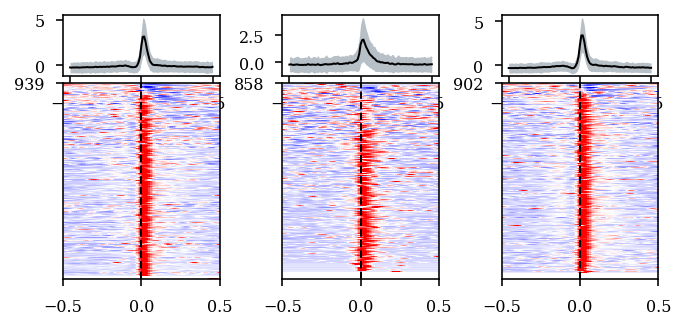

In [156]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=1, subplots=(2, 3)),
    constrained_layout=False,
)
gs = fig.add_gridspec(nrows=4, ncols=3, left=0.05, right=0.75, hspace=0.1, wspace=0.4)

ax0 = fig.add_subplot(gs[0, 0])
psth = psth_df.values[
    :,
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics["epoch"] == 0),
]
psth = stats.zscore(psth, axis=0)
lower, upper = std_upper_lower(psth)
ax0.plot(psth_df.index, np.nanmean(psth, axis=1), "k", linewidth=1)
ax0.fill_between(psth_df.index, lower, upper, color="slategrey", alpha=0.5, linewidth=0)

ax1 = fig.add_subplot(gs[0, 1])
psth = psth_df.values[
    :,
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics["epoch"] == 1),
]
psth = stats.zscore(psth, axis=0)
lower, upper = std_upper_lower(psth)
ax1.plot(psth_df.index, np.nanmean(psth, axis=1), "k", linewidth=1)
ax1.fill_between(psth_df.index, lower, upper, color="slategrey", alpha=0.5, linewidth=0)

ax2 = fig.add_subplot(gs[0, 2])
psth = psth_df.values[
    :,
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics["epoch"] == 2),
]
psth = stats.zscore(psth, axis=0)
lower, upper = std_upper_lower(psth)
ax2.plot(psth_df.index, np.nanmean(psth, axis=1), "k", linewidth=1)
ax2.fill_between(psth_df.index, lower, upper, color="slategrey", alpha=0.5, linewidth=0)


ax3 = fig.add_subplot(gs[1:, 0])
plot_psth_matrix(
    psth_df,
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics["epoch"] == 0),
    ax=ax3,
)

ax4 = fig.add_subplot(gs[1:, 1])
plot_psth_matrix(
    psth_df,
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics["epoch"] == 1),
    ax=ax4,
)
ax5 = fig.add_subplot(gs[1:, 2])
plot_psth_matrix(
    psth_df,
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics["epoch"] == 2),
    ax=ax5,
)

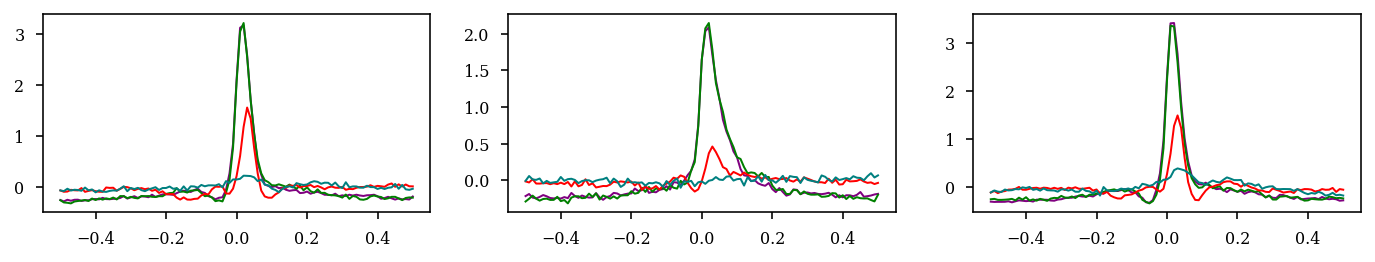

In [176]:
def make_this_plot(psth_df, idx, color="slategrey",ax=None):
    psth = psth_df.values[:, idx]
    psth = stats.zscore(psth, axis=0)
    lower, upper = std_upper_lower(psth)
    ax.plot(psth_df.index, np.nanmean(psth, axis=1), color=color, linewidth=1)
    # plt.fill_between(
    #     psth_df.index, lower, upper, color=color, alpha=0.5, linewidth=0
    # )

fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=2, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = axs.ravel()

for i in range(3):
    make_this_plot(
        psth_df,
        cell_metrics.brainRegion.str.contains("CA1").values
        & (cell_metrics.deepSuperficial == "Deep")
        & (cell_metrics["epoch"] == i),
        color="purple",
        ax=ax[i]
    )
    make_this_plot(
        psth_df,
        cell_metrics.brainRegion.str.contains("CA1").values
        & (cell_metrics.deepSuperficial == "Superficial")
        & (cell_metrics["epoch"] == i),
        color="green",
        ax=ax[i]
    )
            

    make_this_plot(
        psth_df,
        cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").values
        & (cell_metrics["epoch"] == i),
        color="red",
        ax=ax[i]
    )
    make_this_plot(
        psth_df,
        cell_metrics.brainRegion.str.contains("PFC").values
        & (cell_metrics["epoch"] == i),
        color="teal",
        ax=ax[i]
    )

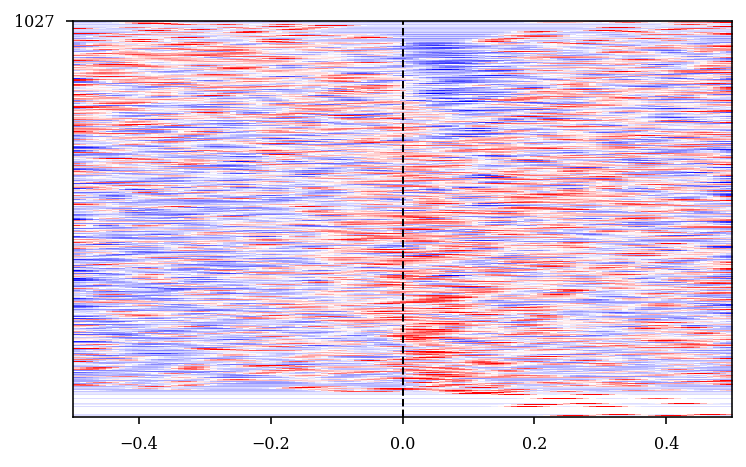

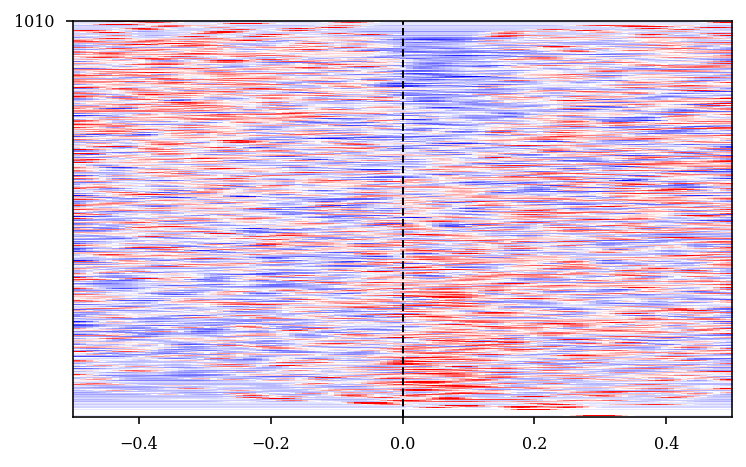

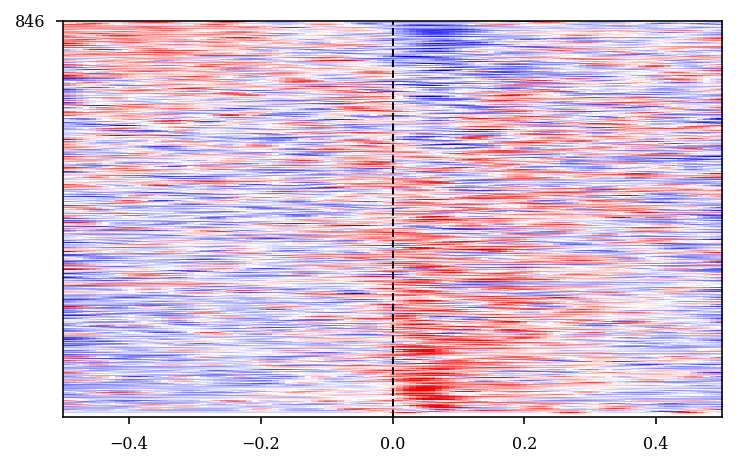

In [184]:
plt.figure(figsize=functions.set_size("thesis", fraction=1, subplots=(1,1)))
plot_psth_matrix(
    psth_df,
    cell_metrics.brainRegion.str.contains("PFC").values
    & (cell_metrics["epoch"] == 0),
    ax=plt.gca(),
)

plt.figure(figsize=functions.set_size("thesis", fraction=1, subplots=(1,1)))
plot_psth_matrix(
    psth_df,
    cell_metrics.brainRegion.str.contains("PFC").values
    & (cell_metrics["epoch"] == 1),
    ax=plt.gca(),
)

plt.figure(figsize=functions.set_size("thesis", fraction=1, subplots=(1,1)))
plot_psth_matrix(
    psth_df,
    cell_metrics.brainRegion.str.contains("PFC").values
    & (cell_metrics["epoch"] == 2),
    ax=plt.gca(),
)